In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
enable_wandb = True
if enable_wandb:
    import wandb
    wandb.login()

In [5]:
from torch_geometric.datasets import TUDataset

In [46]:
from substructures import get_rings, get_substructure_edge_index, get_node_counts
import torch
def pre_transform(graph):
    substructures = [get_rings(graph.edge_index, max_k =i, min_k = i) for i in range(3,7)]
    substructures_edge_index = [get_substructure_edge_index(substructure) for substructure in substructures]
    return graph.update({"substructures_edge_index": substructures_edge_index})

In [39]:
def add_empty_substructures(graph):
    return graph.update({"substructures_edge_index": [torch.tensor([[],[]], dtype = int)]})
dataset = TUDataset(root=f'/tmp/{DATASET_NAME}', name=DATASET_NAME, pre_transform=add_empty_substructures, use_node_attr= True)

Processing...
Done!


In [47]:
DATASET_NAME = "PROTEINS"
dataset = TUDataset(root=f'/tmp/{DATASET_NAME}_rings_3_to_6', name=DATASET_NAME, pre_transform = pre_transform, use_node_attr= True)

Extracting /tmp/PROTEINS_rings_3_to_6/PROTEINS/PROTEINS.zip
Processing...
Done!


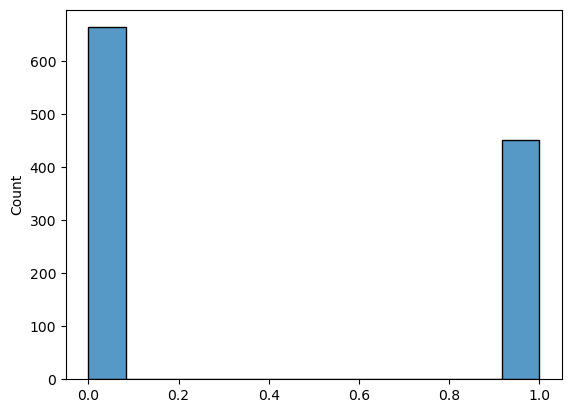

In [8]:
import seaborn as sns
from itertools import chain
sns.histplot(list(map(lambda x: int(x), list(chain(*[graph.y for graph in dataset])))))

In [48]:
dataset[0].substructures_edge_index

[tensor([[13, 14, 39, 12, 31, 41,  3,  4, 38, 12, 33, 41,  4, 14, 39, 16, 18, 19,
           1, 31, 41, 19, 20, 21,  0, 11, 22,  8,  9, 35,  3,  4, 28,  9, 19, 21,
           5,  6,  7, 16, 17, 19,  8,  9, 10, 23, 31, 41,  8,  9, 25, 18, 19, 35,
          17, 18, 19,  1, 23, 41, 12, 31, 33, 16, 17, 18,  3,  4, 39,  9, 19, 35,
          31, 33, 41, 13, 14, 15,  0, 11, 32,  3,  4, 29,  1, 23, 31],
         [ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,  5,
           6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11, 11, 11,
          12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16, 17, 17, 17,
          18, 18, 18, 19, 19, 19, 20, 20, 20, 21, 21, 21, 22, 22, 22, 23, 23, 23,
          24, 24, 24, 25, 25, 25, 26, 26, 26, 27, 27, 27, 28, 28, 28]]),
 tensor([[22, 30, 32, 40,  0, 22, 30, 32, 23, 31, 33, 34,  2, 24, 33, 34,  2, 24,
          23, 34, 11, 22, 30, 32,  6,  7, 25,  8,  0, 22, 40, 32,  7, 19,  9, 25,
          23, 24, 33, 34, 23, 24, 33

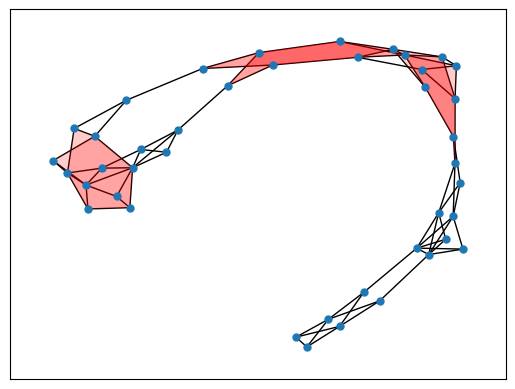

In [49]:
import visualization as vis

graph = dataset[0]
rings = get_rings(graph.edge_index, max_k =6, min_k = 6)
vis.visualize(graph, substructure = rings)


In [50]:
from torch_geometric.loader import DataLoader

In [51]:
torch.manual_seed(0)
dataset = dataset.shuffle()
train_num = int(len(dataset) * 0.6)
val_num = int(len(dataset) * 0.2)
train_dataset = dataset[:train_num]
val_dataset = dataset[train_num:train_num + val_num]
test_dataset = dataset[train_num + val_num:]
train_loader = DataLoader(train_dataset, batch_size = 16)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)


In [52]:
hyper = {"lr":0.01, 
         "weight_decay":5e-4, 
         "num_layers":3, 
         "batch_size": 16, 
         "hidden_channels": 16, 
         "substructures": ["triangles", "squares"], 
         "dataset": DATASET_NAME, 
         "target": "class", 
         "node_level_predictions": False, 
         "max_epochs": 50}

In [53]:
import simple_model_triangles
model = simple_model_triangles.SimpleSubstructureNeuralNetGraph(hidden_channels=hyper["hidden_channels"], out_channels=dataset.num_classes, in_channels = dataset.num_node_features, num_layers=hyper["num_layers"], num_substructures=2)

In [54]:
print(model)

SimpleSubstructureNeuralNetGraph(
  (layers): ModuleList(
    (0): SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=4, out_features=32, bias=True)
        (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=32, out_features=16, bias=True)
      ))
      (node2substructures): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
      (substructures2node): ModuleList(
        (0-1): 2 x Sequential(
          (0): Linear(in_features=16, out_features=32, bias=True)
          (1): ReLU()
          (2): Linear(in_features=32, out_features=16, bias=True)
        )
      )
    )
    (1-2): 2 x SubstructureLayer(
      (message_neighbor): GINConv(nn=Sequential(
        (0): Linear(in_features=16, out_f

In [55]:
from trainer import GraphNetGraphClassification
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer

wandb_logger = WandbLogger(project='proteins dataset', name= "first test without substructure messages")
wandb_logger.experiment.config.update(hyper)
#wandb_logger.watch(model, log="all")

trainer = Trainer(max_epochs=hyper["max_epochs"], logger= wandb_logger, enable_progress_bar= False, log_every_n_steps=15)
model_lightning = GraphNetGraphClassification(model, lr = hyper["lr"], weight_decay = hyper["weight_decay"])

trainer.fit(model_lightning, train_dataloaders=train_loader, val_dataloaders= val_loader)
wandb.finish()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type                             | Params
------------------------------------------------------------
0 | model  | SimpleSubstructureNeuralNetGraph | 16.5 K
1 | metric | CrossEntropyLoss                 | 0     
------------------------------------------------------------
16.5 K    Trainable params
0         Non-trainable params
16.5 K    Total params
0.066     Total estimated model params size (MB)
/Users/niklas/anaconda3/envs/substructureML/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/niklas/an

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_loss,▆█▅▅▆▅▃▅▅▅▃▄▆▃▅▁▃▆▆▄▃▅▆▂▃▃▅▂▃▃▄▂▁▃▄▃▃▆▅▃
val_acc,▅▇▂▂▃▃▃▃▃▂▃▄▄▇▇▄▆█▆▆▄▆▇▇▆▆▆▇▆▇▆▇▇▇▆▇▆▁█▇
val_loss,█▂▃▃▂▃▂▃▂▃▃▂▄▂▂▃▂▁▂▁▃▂▁▁▂▂▂▁▂▁▂▂▁▁▂▁▂▅▁▂
epoch,49
trainer/global_step,2099
training_loss,0.55134
val_acc,0.69834
val_loss,0.58813
